# Проект по анализу результатов A/B-теста на сайте
Наша задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- Оценим корректность проведения теста.
- Проанализируем результаты теста.


 **Чтобы оценить корректность проведения теста, проверем:**
- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import datetime as dt
import math as mth
import plotly.express as px
from plotly import graph_objects as go

In [ ]:

try:
  events = pd.read_csv('/content/ab_project_marketing_events.csv')
  final_events = pd.read_csv('/content/final_ab_events.csv')
  new_users = pd.read_csv('/content/final_ab_new_users.csv')
  particip = pd.read_csv('/content/final_ab_participants.csv')
except :
  events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
  final_events = pd.read_csv('/datasets/final_ab_events.csv')
  new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
  particip = pd.read_csv('/datasets/final_ab_participants.csv')

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [ ]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [ ]:
events['start_dt'] = pd.to_datetime(events['start_dt'])
events['finish_dt'] = pd.to_datetime(events['finish_dt'])
events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [ ]:
final_events.info()
final_events['event_dt'] = pd.to_datetime(final_events['event_dt'], format='%Y-%m-%dT%H:%M:%S')
final_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [ ]:
new_users.info()
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [ ]:
particip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [ ]:
print(events.duplicated().sum())
print(final_events.duplicated().sum())
print(new_users.duplicated().sum())
print(particip.duplicated().sum())

0
0
0
0


## Выводы
Данные подготовлены для анализа: столбцы даты приведены в нужному формату.
Пропуски в данных отсутствуют, за исключением final_events details - по условию оговорено, что это не обязательное поле, там по некоторым заказам хранятся детали покупки.
Полные дубликаты отсутствуют

In [ ]:
print(final_events[final_events['details'].isnull()]['details'].isnull().sum())
print(final_events[final_events['details'].isnull()]['details'].shape[0])

377577
377577


Проверяем пропуски в столбце details по всем ивентам,кроме покупки. Все корректно, пропуски есть во всех ивентах, кроме покупки.

# Исследовательский анализ данных

In [ ]:
print(new_users['first_date'].min())
print(new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


In [ ]:
date_end_test = pd.to_datetime('2020-12-21' , format ='%Y-%m-%d')
new_users = new_users.query('region == "EU" and first_date <= @date_end_test ')

In [ ]:
all_users = final_events.merge(new_users , on ='user_id')
df = all_users.merge(particip , on ='user_id')
df.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-07,EU,iPhone,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,EU,iPhone,B,interface_eu_test


In [ ]:
df['group'].value_counts()

A    56882
B    42348
Name: group, dtype: int64

In [ ]:
print('В итоговом df пользователей,которые участвуют в тестировании {}'.format(len(df['user_id'].unique())))
print('В итоговом df пользователели совершили {} собыйтий.'.format(len(df['event_name'])))

В итоговом df пользователей,которые участвуют в тестировании 12442
В итоговом df пользователели совершили 99230 собыйтий.


In [ ]:
check_ab_groups = df.pivot_table(index ='user_id' , values ='group' , aggfunc='nunique').reset_index()
check_ab_groups = check_ab_groups[check_ab_groups['group']>1]

In [ ]:
print('В df пользователей,которых записали в оба теста {}'.format(len(check_ab_groups)))

В df пользователей,которых записали в оба теста 441


In [ ]:
df['ab_test'].value_counts()

interface_eu_test          75810
recommender_system_test    23420
Name: ab_test, dtype: int64

In [ ]:
print(new_users.query('region == "EU"')['user_id'].count())
rec_eu = len(particip.query('ab_test == "recommender_system_test"')['user_id'].isin(new_users.query('region == "EU"')['user_id'].unique()))
print(rec_eu)
print(round(rec_eu / new_users.query('region == "EU"')['user_id'].count() , 3)*100)

42340
6701
15.8


Процент пользователей из EU соответствует ожидаемому - 15%
Участников теста 6701

In [ ]:
# формируем только необходимый тест и регион
rec_sys_test = df.query('ab_test == "recommender_system_test" & region == "EU"')
rec_sys_test

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
12,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
13,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test
14,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
15,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
16,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...
99210,1484BBF124DB1B18,2020-12-27 10:53:34,login,NaN,2020-12-21,EU,PC,A,recommender_system_test
99213,BEF16764A13AEC34,2020-12-21 03:49:49,login,NaN,2020-12-21,EU,PC,B,recommender_system_test
99215,BEF16764A13AEC34,2020-12-22 18:52:25,login,NaN,2020-12-21,EU,PC,B,recommender_system_test
99217,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,2020-12-21,EU,PC,B,recommender_system_test


In [ ]:
rec_sys_test.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


Пользователей,которые попали в две группы нет

In [ ]:
rec_sys_test = rec_sys_test[(rec_sys_test['event_dt'] - rec_sys_test['first_date']).dt.days <= 14]

# События

In [ ]:
rec_sys_test['day'] = rec_sys_test['event_dt'].dt.date

<ipython-input-22-3b455f038ca2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_sys_test['day'] = rec_sys_test['event_dt'].dt.date


In [ ]:
by_date = rec_sys_test.groupby(['day' , 'group']).agg({'event_name':'count'}).reset_index()
by_date.head()

,day,group,event_name
0,2020-12-07,A,318
1,2020-12-07,B,356
2,2020-12-08,A,313
3,2020-12-08,B,238
4,2020-12-09,A,371


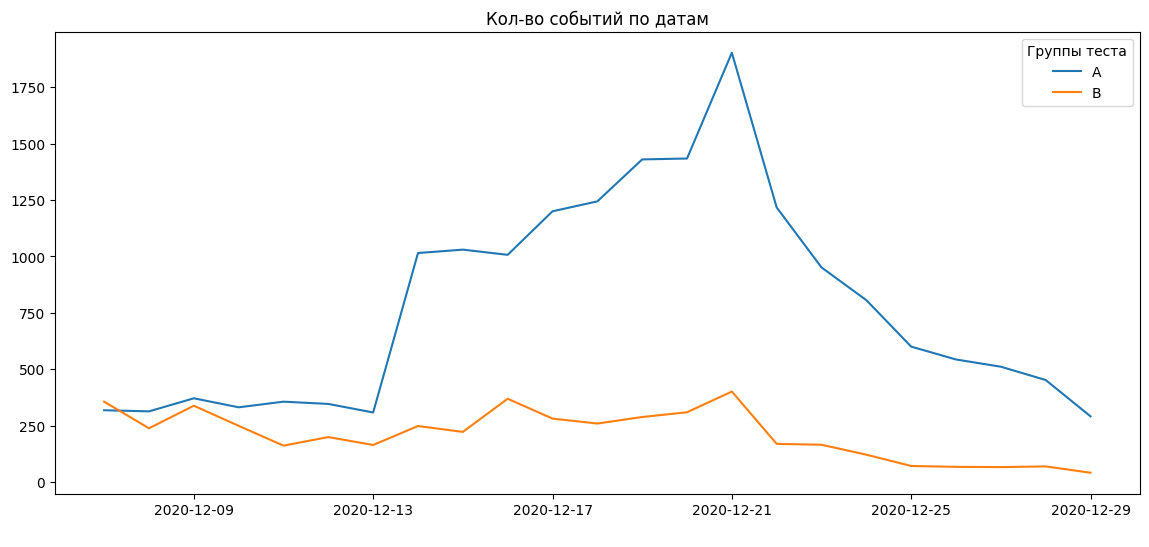

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(by_date[by_date['group'] == 'A']['day'], by_date[by_date['group'] == 'A']['event_name'], label='A')
plt.plot(by_date[by_date['group'] == 'B']['day'], by_date[by_date['group'] == 'B']['event_name'], label='B')


plt.title('Кол-во событий по датам')
plt.xlabel(' ')
plt.legend(title='Группы теста')
plt.show()

Самый яркий пик на графике : 2020-12-21 , обе выборки показывают максимальные значения.
Кол-во участников в выборке так же сильно отличается.

In [ ]:
events.query('name == "Christmas&New Year Promo"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Тестирование происходит в дни праздника : Christmas&New Year Promo

In [ ]:
print(rec_sys_test.query('group == "A"')['day'].min())
print(rec_sys_test.query('group == "A"')['day'].max())
print(' ')
print(rec_sys_test.query('group == "B"')['day'].min())
print(rec_sys_test.query('group == "B"')['day'].max())

2020-12-07
2020-12-29
 
2020-12-07
2020-12-29


Дата окончания сбора пользователей отличается у группы А и Б - это ошибка, при проведении АБ тестироания

In [ ]:
print('Пользователей группы А {} шт.'.format(len(rec_sys_test.query('group == "A"')['user_id'].unique())))
print('Событий группы А {} шт.'.format(rec_sys_test.query('group == "A"')['event_name'].count()))

print('Пользователей группы B {} шт.'.format(len(rec_sys_test.query('group == "B"')['user_id'].unique())))
print('Событий группы B {} шт.'.format(rec_sys_test.query('group == "B"')['event_name'].count()))

print('В среднем на пользователя в группе А приходится {} '.format(rec_sys_test.query('group == "A"')['event_name'].count() /len(rec_sys_test.query('group == "A"')['user_id'].unique()) ))
print('В среднем на пользователя в группе B приходится {} '.format(rec_sys_test.query('group == "B"')['event_name'].count() /len(rec_sys_test.query('group == "B"')['user_id'].unique()) ))

Пользователей группы А 2604 шт.
Событий группы А 17977 шт.
Пользователей группы B 877 шт.
Событий группы B 4851 шт.
В среднем на пользователя в группе А приходится 6.903609831029186 
В среднем на пользователя в группе B приходится 5.531356898517674 


# Воронка пользователей



In [ ]:
rec_sys_test.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,2604
B,877


Группы распределены неравномерно. Контрольная группа отличается практически в 3 раза.

In [ ]:
funnel = rec_sys_test.groupby('event_name').agg({'region':'count'}).reset_index().sort_values('region' , ascending = False)
funnel

,event_name,region
0,login,10313
2,product_page,6382
3,purchase,3123
1,product_cart,3010


Пользователь заходит в аккаунт, Посещает страницу продукта
Посещает корзину, Оплачивает покупку

Последние два пункта производятся не обязательно по порядку, покупку можно оплатить сразу, не переходя в корзину

In [ ]:

logina_user = rec_sys_test.query('group == "A" & event_name =="login"')['user_id'].unique()
loginb_user = rec_sys_test.query('group == "B" & event_name =="login"')['user_id'].unique()
product_pagea_user = rec_sys_test.query('group == "A" & event_name =="product_page"')['user_id'].unique()
product_pageb_user = rec_sys_test.query('group == "B" & event_name =="product_page"')['user_id'].unique()
product_carta_user = rec_sys_test.query('group == "A" & event_name =="product_cart"')['user_id'].unique()
product_cartb_user = rec_sys_test.query('group == "B" & event_name =="product_cart"')['user_id'].unique()
purchasea_user = rec_sys_test.query('group == "A" & event_name =="purchase"')['user_id'].unique()
purchaseb_user = rec_sys_test.query('group == "B" & event_name =="purchase"')['user_id'].unique()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y=['Login', 'Product page', 'Product cart', 'Purchase'],
    x=[len(logina_user), len(product_pagea_user), len(product_carta_user), len(purchasea_user)],
    textinfo = "value+percent previous",
    marker={'color':'blueviolet'}))

fig.add_trace(go.Funnel(
    name = 'Группа В',
    y=['Login', 'Product page', 'Product cart', 'Purchase'],
    x=[len(loginb_user), len(product_pageb_user), len(product_cartb_user), len(purchaseb_user)],
    textinfo = "value+percent previous",
    marker={'color':'violet'}))

fig.show()

Среди группы А:
- На продуктовую страницу переходят 65%
- На страницу корзины 46 %
- Осуществляют покупку 32% от изначальных пользователей

Среди группы Б:
- На продуктовую страницу переходят 56%
- На страницу корзины 49 %
- Осуществляют покупку 28% от изначальных пользователей

## Вывод

- По условиям теста выборка должна содержать 6000 пользователей, по факту 3481
- 441 пользователь участвовали в разных тестах
- Процент пользователей из ЕС не соответствует ожидаемому
- Тест проводится в период праздников, его результаты нельзя применять к остальному году
- Сбор пользователей закончился в разные дни и не соответствует ТЗ

## Проверка гипотез
**Нулевая гипотеза**: доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

**Альтенативная гипотеза**: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [ ]:
# формируем выборки пользователей по этапам воронки

ppa = rec_sys_test.query('group == "A" & event_name =="product_page" & user_id in @logina_user')['user_id'].unique()
ppb = rec_sys_test.query('group == "B" & event_name =="product_page" & user_id in @loginb_user')['user_id'].unique()

pca = rec_sys_test.query('group == "A" & event_name =="product_cart" & user_id in @ppa')['user_id'].unique()
pcb = rec_sys_test.query('group == "B" & event_name =="product_cart" & user_id in @ppb')['user_id'].unique()

pa = rec_sys_test.query('group == "A" & event_name =="purchase" & user_id in @pca')['user_id'].unique()
pb = rec_sys_test.query('group == "B" & event_name =="purchase" & user_id in @pcb')['user_id'].unique()


In [ ]:
# Напишем функцию для проверки гипотез
def get_p(success, trials, alpha):
    p1 = success[0] / trials[0]
    p2 = success[1] / trials[1]
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [ ]:
# Так как у нас идет множественная проверка гипотез, сделаем на это поправку ниже
alpha_total = 0.05
print('При применении поправки Бонферрони : {}'.format(alpha_total / 3))
print('При применении поправки Шидака : {}'.format(1 - (1-alpha_total)**(1/3)))

print('Так как оба значение получились примерно одинаковыми возьмем среднее 0.0168')

При применении поправки Бонферрони : 0.016666666666666666
При применении поправки Шидака : 0.016952427508441503
Так как оба значение получились примерно одинаковыми возьмем среднее 0.0168


In [ ]:
successes_pp = np.array([len(ppa), len(ppb)])
trials_pp = np.array([len(logina_user), len(loginb_user)])
get_p(successes_pp, trials_pp ,0.0168 )

p-значение:  8.195976000324734e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница



In [ ]:
successes_pc = np.array([len(pca), len(pcb)])
trials_pc = np.array([len(ppa), len(ppb)])
get_p(successes_pc, trials_pc ,0.0168 )

p-значение:  0.2516909036278556
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [ ]:
successes_p = np.array([len(pa), len(pb)])
trials_p = np.array([len(pca), len(pcb)])
get_p(successes_p, trials_p ,0.0168 )

p-значение:  0.9142604535464176
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Конверсия с первой страницы товара отличается у групп А и Б. В следующих шагах конверсия статистически значимо не отличается.
По результатам теста в 2-ух из 3-ех выборок тест показал отсутствие значимых различий у выборок, принимаем нулевую гипотезу.

# Вывод
- По условиям теста выборка должна содержать 6000 пользователей, по факту 6701
- 441 пользователь участвовали в разных тестах
- Процент пользователей из ЕС соответствует ожидаемому
- Маркетинговая акция никак не повлияла на наш тест
- По результатам теста в 2-ух из 3-ех выборок тест показал отсутствие значимых различий у выборок, принимаем нулевую гипотезу.

Основные недочеты проведения АБ теста:
- Группы распределены неравномерно
- Часть пользователей попали в параллельно идущий тест interface_eu_test
- Стоит избегать пересечения с маркетинговыми акциями
- Возможно, тест стоит продлить для получения более корректных результатов.